In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re # Import regular expressions
import seaborn as sns


In [2]:
# --- Configuration ---
# List of CSV files containing the ALNS results
# Assumes files are in the same directory as the script
csv_files = [
    "results_makespanSA.csv",
    "results_makespanSA2.csv",
    "results_makespanSA3.csv",
    "results_makespanSA4.csv",
    "results_makespanSA5.csv",
    
]

# List of benchmark files containing reference upper bounds
# Assumes files are in the same directory as the script
benchmark_files = [
    "tai15_15.txt",
    "tai20_15.txt",
    "tai20_20.txt",
    "tai30_15.txt",
    "tai30_20.txt",
    "tai50_15.txt",
    "tai50_20.txt",
    "tai100_20.txt"
]


In [3]:

def load_and_combine_results(file_list):
    """Loads data from multiple CSV files containing algorithm results and combines them."""
    all_data = []
    for f in file_list:
        # Removed os.path.exists check - assuming file exists
        try:
            df = pd.read_csv(f)
            # Use filename directly, assuming it's just the name
            df['source_file'] = f
            all_data.append(df)
            print(f"Successfully loaded results from {f}")
        except FileNotFoundError:
             print(f"Error: Results file not found - {f}. Please ensure it's in the correct directory.")
        except Exception as e:
            print(f"Error loading results {f}: {e}")


    if not all_data:
        print("Error: No results data loaded.")
        return pd.DataFrame()

    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"\nCombined results data has {len(combined_df)} rows.")
    return combined_df

def extract_base_instance(instance_col_series):
    """Extracts the base instance name (e.g., 'tai15_15') from the full instance string."""
    # Assumes format like 'filename.txt - Instance X' or just 'filename.txt'
    pattern = re.compile(r"^(.*?)\.txt")
    # Apply the regex, converting to string first to handle potential non-string types
    extracted_names = instance_col_series.astype(str).apply(
        lambda x: pattern.match(x).group(1) if pattern.match(x) else None
    )
    return extracted_names


# Function to read the instances and bounds from Taillard benchmark files
# Updated with the user's provided logic
def read_instances_from_file(filenames):
    """
    Read and parse multiple Flowshop instances from Taillard text files,
    extracting the upper bound for each instance defined within the files.
    """
    upper_bounds = {} # Initialize dictionary *outside* the loop
    for filename in filenames:
        # Removed os.path.exists check - assuming file exists
        try:
            with open(filename, 'r') as file:
                lines = file.readlines()
                i = 0
                instance_counter = 1 # Counter for instances within *this* file
                while i < len(lines):
                    # Look for the header line indicating a new instance
                    line_stripped = lines[i].strip()
                    if line_stripped.startswith("Nb of jobs"):
                        # The next line contains the parameters
                        if i + 1 < len(lines):
                            parts = [val for val in lines[i + 1].strip().split() if val] # Split and remove empty strings
                            if len(parts) > 4:
                                # Extract num_jobs, num_machines, and the upper bound (5th value, index 4)
                                num_jobs = int(parts[0])
                                num_machines = int(parts[1])
                                upper_bound = int(parts[4]) # Assuming upper bound is the 5th value

                                # Construct the instance name matching the results CSV format
                                # Use filename directly as path/basename separation is not needed
                                instance_name = f"{filename} - Instance {instance_counter}"
                                upper_bounds[instance_name] = upper_bound
                                print(f"Extracted Upper Bound for {instance_name}: {upper_bound}")

                                # Calculate how many lines to skip to get to the next instance header
                                # Header line (1) + Parameter line (1) + Times lines (num_jobs) + Machines line (1) + Machines data lines (num_jobs)
                                lines_to_skip = 1 + 1 + num_jobs + 1 + num_jobs
                                i += lines_to_skip
                                instance_counter += 1
                            else:
                                print(f"Warning: Could not parse parameters line in {filename}: {lines[i+1].strip()}")
                                i += 1 # Move to next line to avoid infinite loop
                        else:
                             print(f"Warning: Header found but no data line following in {filename} at line {i}")
                             i += 1 # Header found but no data line? Move to next line.
                    else:
                        i += 1 # Move to the next line if it's not a header
        except FileNotFoundError:
            print(f"Error: Benchmark file not found - {filename}. Please ensure it's in the correct directory.")
            continue # Skip to next file
        except Exception as e:
            print(f"Error reading or parsing benchmark file {filename}: {e}")
            # Continue to the next file even if one fails
            continue
    return upper_bounds


def separate_by_instance(df, benchmark_bounds):
    """
    Separates the combined dataframe into a dictionary of dataframes,
    one per base instance, and adds the reference upper bound based on the full instance name.
    """
    if 'Instance' not in df.columns or df.empty:
        print("Error: 'Instance' column missing or DataFrame empty.")
        return {}

    # Extract base instance name mainly for grouping/reporting purposes
    df['base_instance'] = extract_base_instance(df['Instance'])

    # Add the reference upper bound using the *full* instance name for lookup
    # The 'Instance' column from CSV should match the keys generated by read_instances_from_file
    df['UpperBound_Ref'] = df['Instance'].map(benchmark_bounds)
    df["error"]=(df["Optimized Makespan"]-df['UpperBound_Ref'])/df['UpperBound_Ref']
    # Handle parsing issues for base_instance (optional, for grouping)
    if df['base_instance'].isnull().any():
        print("Warning: Some base instance names could not be parsed from results.")

    # Handle missing upper bounds
    if df['UpperBound_Ref'].isnull().any():
        print("\nWarning: Some results rows did not match a benchmark upper bound:")
        missing_instances = df[df['UpperBound_Ref'].isnull()]['Instance'].unique()
        print(f"Instances without matching bounds: {list(missing_instances)}")


    # Group by BASE instance name for the dictionary structure
    instance_dfs = {}
    for name, group in df.groupby('base_instance'):
        if name is not None: # Ensure group name is valid
            instance_dfs[name] = group.copy() # Store the group (which now includes UpperBound_Ref)
        else:
            print("Warning: Found group with no base_instance name during separation.")


    print(f"\nSeparated data into {len(instance_dfs)} base instances: {list(instance_dfs.keys())}")
    # Check if any instance group is missing a reference bound (might indicate partial match)
    for name, df_instance in instance_dfs.items():
        if 'UpperBound_Ref' not in df_instance.columns or df_instance['UpperBound_Ref'].isnull().all():
            print(f"Warning: Base instance group '{name}' has no reference Upper Bounds assigned.")
        elif df_instance['UpperBound_Ref'].isnull().any():
             print(f"Warning: Some rows within base instance group '{name}' are missing reference Upper Bounds.")


    return instance_dfs

In [4]:

# --- Graphing Function Example ---

def plot_makespan_vs_hyperparameter(instance_df, instance_name, hyperparameter_col, value_col='Optimized Makespan'):
    """
    Generates a box plot comparing a value column (e.g., Optimized Makespan)
    across different values of a specified hyperparameter for a given instance group.
    Plots the reference upper bound found in the first row of the group as a guide.
    """
    if instance_df.empty:
        print(f"No data to plot for instance group {instance_name}.")
        return
    if hyperparameter_col not in instance_df.columns:
        print(f"Error: Hyperparameter column '{hyperparameter_col}' not found for instance group {instance_name}.")
        return
    if value_col not in instance_df.columns:
        print(f"Error: Value column '{value_col}' not found for instance group {instance_name}.")
        return

    plt.figure(figsize=(12, 7))
    # Convert hyperparameter column to string for categorical plotting if it's numeric
    instance_df_plot = instance_df.copy()
    # Ensure the hyperparameter column exists before attempting conversion
    if hyperparameter_col in instance_df_plot.columns:
        instance_df_plot[hyperparameter_col] = instance_df_plot[hyperparameter_col].astype(str)
    else:
        # Handle the case where the column might be missing after all, though checked above
        print(f"Error: Column '{hyperparameter_col}' still missing before plotting.")
        return


    sns.boxplot(data=instance_df_plot, x=hyperparameter_col, y=value_col)

    # Check if reference upper bound exists and plot the first one found for this group
    # Note: This assumes the upper bound is the same for all sub-instances within the base group.
    # If bounds differ, this line represents only one of them.
    if 'UpperBound_Ref' in instance_df.columns and not instance_df['UpperBound_Ref'].isnull().all():
        # Find the first non-NaN value in the reference column for this group
        valid_bounds = instance_df['UpperBound_Ref'].dropna()
        if not valid_bounds.empty:
            ref_bound = valid_bounds.iloc[0] # Get the first non-NaN bound value
            plt.axhline(ref_bound, color='r', linestyle='--', label=f'Upper Bound Ref ({int(ref_bound)})')
            plt.legend()
            print(f"Plotting reference line using Upper Bound: {int(ref_bound)} for instance group {instance_name}")
        else:
            print(f"Could not find a valid reference bound value to plot for instance group {instance_name}")


    plt.title(f'{value_col} vs {hyperparameter_col} for Instance Group {instance_name}')
    plt.xlabel(hyperparameter_col)
    plt.ylabel(value_col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



In [5]:

# --- Main Execution ---

# 1. Load benchmark upper bounds using the corrected function
benchmark_upper_bounds = read_instances_from_file(benchmark_files)
# print("\nReference Upper Bounds Loaded:", benchmark_upper_bounds)
print(benchmark_upper_bounds)
df_ub=pd.DataFrame.from_dict(benchmark_upper_bounds,columns=["instance,UB"],orient='index')
print(df_ub)

df_ub.to_excel("ub_registers.xlsx")


Extracted Upper Bound for tai15_15.txt - Instance 1: 1231
Extracted Upper Bound for tai15_15.txt - Instance 2: 1244
Extracted Upper Bound for tai15_15.txt - Instance 3: 1222
Extracted Upper Bound for tai15_15.txt - Instance 4: 1181
Extracted Upper Bound for tai15_15.txt - Instance 5: 1233
Extracted Upper Bound for tai15_15.txt - Instance 6: 1243
Extracted Upper Bound for tai15_15.txt - Instance 7: 1228
Extracted Upper Bound for tai15_15.txt - Instance 8: 1220
Extracted Upper Bound for tai15_15.txt - Instance 9: 1282
Extracted Upper Bound for tai15_15.txt - Instance 10: 1259
Extracted Upper Bound for tai20_15.txt - Instance 1: 1376
Extracted Upper Bound for tai20_15.txt - Instance 2: 1377
Extracted Upper Bound for tai20_15.txt - Instance 3: 1367
Extracted Upper Bound for tai20_15.txt - Instance 4: 1345
Extracted Upper Bound for tai20_15.txt - Instance 5: 1366
Extracted Upper Bound for tai20_15.txt - Instance 6: 1371
Extracted Upper Bound for tai20_15.txt - Instance 7: 1480
Extracted Upp

In [6]:

# 2. Load and combine algorithm results data
all_results_df = load_and_combine_results(csv_files)
if not all_results_df.empty:
    # 3. Separate data by base instance name and add reference bounds using full instance name match
    results_by_instance = separate_by_instance(all_results_df, benchmark_upper_bounds)
    print(results_by_instance)


Successfully loaded results from results_makespanSA.csv
Successfully loaded results from results_makespanSA2.csv
Successfully loaded results from results_makespanSA3.csv
Successfully loaded results from results_makespanSA4.csv
Successfully loaded results from results_makespanSA5.csv

Combined results data has 1200 rows.

Separated data into 8 base instances: ['tai100_20', 'tai15_15', 'tai20_15', 'tai20_20', 'tai30_15', 'tai30_20', 'tai50_15', 'tai50_20']
{'tai100_20':                          Instance  n_jobs  n_machines  p_iterations  p_pct  \
70     tai100_20.txt - Instance 1     100          20           100    0.2   
71     tai100_20.txt - Instance 2     100          20           100    0.2   
72     tai100_20.txt - Instance 3     100          20           100    0.2   
73     tai100_20.txt - Instance 4     100          20           100    0.2   
74     tai100_20.txt - Instance 5     100          20           100    0.2   
...                           ...     ...         ...      


Separated data into 8 base instances: ['tai100_20', 'tai15_15', 'tai20_15', 'tai20_20', 'tai30_15', 'tai30_20', 'tai50_15', 'tai50_20']

Generating plot for instance group: tai50_20
Reference Upper Bound (example from group): 2868
Plotting reference line using Upper Bound: 2868 for instance group tai50_20


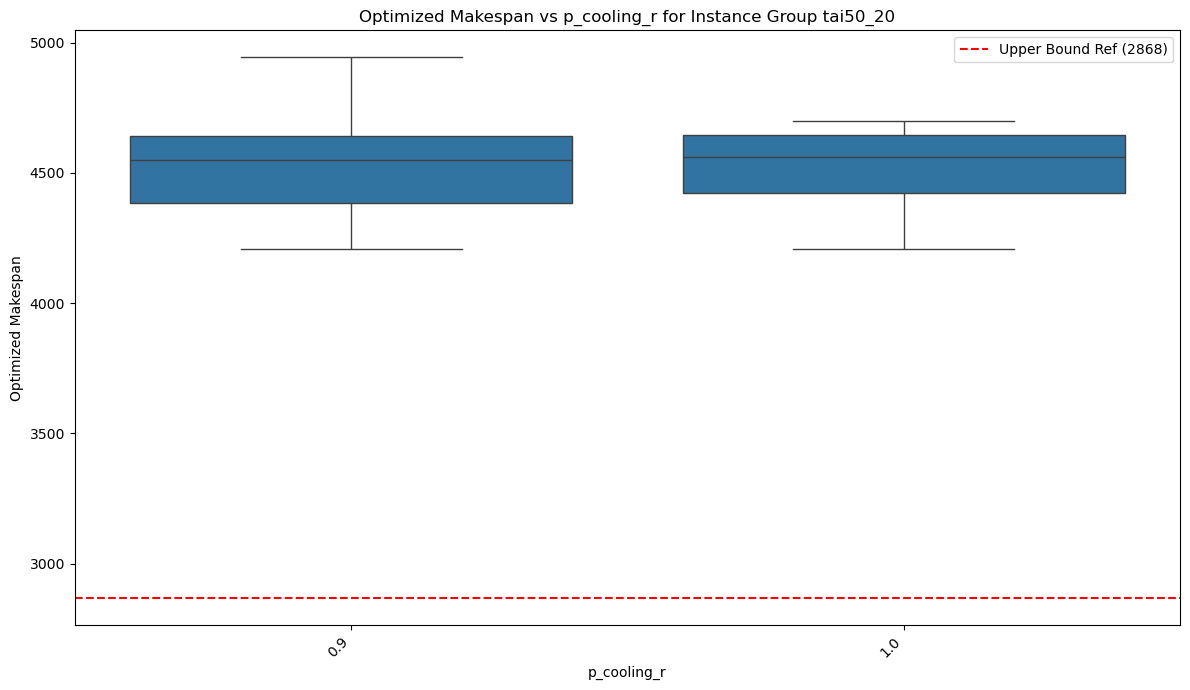


Sample data for tai50_20 including reference bound:
                     Instance  p_cooling_r  Optimized Makespan  UpperBound_Ref
60  tai50_20.txt - Instance 1          0.9                4577            2868
61  tai50_20.txt - Instance 2          0.9                4642            2902
62  tai50_20.txt - Instance 3          0.9                4210            2755
63  tai50_20.txt - Instance 4          0.9                4377            2702
64  tai50_20.txt - Instance 5          0.9                4536            2725


In [7]:

if not all_results_df.empty:
    # 3. Separate data by base instance name and add reference bounds using full instance name match
    results_by_instance = separate_by_instance(all_results_df, benchmark_upper_bounds)

    # 4. Example: Plot results for a specific base instance group and hyperparameter
    target_instance_name = "tai50_20" # Choose a base instance group to plot
    hyperparameter_to_plot = "p_cooling_r" # Choose a hyperparameter column

    if target_instance_name in results_by_instance:
        print(f"\nGenerating plot for instance group: {target_instance_name}")
        # Access the specific DataFrame for the instance group
        instance_data_to_plot = results_by_instance[target_instance_name]

        # Check if *any* reference bound was successfully added before plotting
        if 'UpperBound_Ref' in instance_data_to_plot.columns and not instance_data_to_plot['UpperBound_Ref'].isnull().all():
             # Print the first valid bound found for reference
             first_valid_bound = instance_data_to_plot['UpperBound_Ref'].dropna()
             if not first_valid_bound.empty:
                 print(f"Reference Upper Bound (example from group): {first_valid_bound.iloc[0]}")
             else:
                 print(f"Warning: No valid reference Upper Bound found for plotting {target_instance_name}")

        else:
             print(f"Warning: No reference Upper Bound column found or all values are NaN for plotting {target_instance_name}")

        plot_makespan_vs_hyperparameter(
            instance_data_to_plot,
            target_instance_name,
            hyperparameter_to_plot
        )

        # Display some data including the reference bound
        print(f"\nSample data for {target_instance_name} including reference bound:")
        # Select columns robustly, checking if they exist first
        cols_to_show = ['Instance', hyperparameter_to_plot, 'Optimized Makespan', 'UpperBound_Ref']
        cols_exist = [col for col in cols_to_show if col in instance_data_to_plot.columns]
        print(instance_data_to_plot[cols_exist].head())


    else:
        print(f"\nInstance group '{target_instance_name}' not found in the results.")

else:
    print("\nNo results data was loaded, cannot proceed with analysis.")

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import os # Removed os import
import re # Import regular expressions
import numpy as np # Added numpy for potential NaN handling

# --- Configuration ---
# List of CSV files containing the ALNS results
# Assumes files are in the same directory as the script
csv_files = [
    "results_makespanSA.csv",
    "results_makespanSA2.csv",
    "results_makespanSA3.csv",
    "results_makespanSA4.csv",
    "results_makespanSA5.csv",
    "results_makespanSA6.csv",
    "results_makespanSA7.csv",
    "results_makespanSA10.csv"
]

# List of benchmark files containing reference upper bounds
# Assumes files are in the same directory as the script
benchmark_files = [
    "tai15_15.txt",
    "tai20_15.txt",
    "tai20_20.txt",
    "tai30_15.txt",
    "tai30_20.txt",
    "tai50_15.txt",
    "tai50_20.txt",
    "tai100_20.txt"
]

# Define the columns that represent the hyperparameters
# Adjust this list based on the actual column names in your CSV files
hyperparameter_columns = [
    'p_iterations',
    'p_pct',
    'p_lambda',
    'p_tabootenure',
    'p_cooling_r',
    'p_max_iters_nomejor'
]


# --- Data Loading and Processing ---

def load_and_combine_results(file_list):
    """Loads data from multiple CSV files containing algorithm results and combines them."""
    all_data = []
    for f in file_list:
        # Removed os.path.exists check - assuming file exists
        try:
            df = pd.read_csv(f)
            # Use filename directly, assuming it's just the name
            df['source_file'] = f
            all_data.append(df)
            print(f"Successfully loaded results from {f}")
        except FileNotFoundError:
             print(f"Error: Results file not found - {f}. Please ensure it's in the correct directory.")
        except Exception as e:
            print(f"Error loading results {f}: {e}")


    if not all_data:
        print("Error: No results data loaded.")
        return pd.DataFrame()

    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"\nCombined results data has {len(combined_df)} rows.")
    return combined_df

def extract_base_instance(instance_col_series):
    """Extracts the base instance name (e.g., 'tai15_15') from the full instance string."""
    # Assumes format like 'filename.txt - Instance X' or just 'filename.txt'
    pattern = re.compile(r"^(.*?)\.txt")
    # Apply the regex, converting to string first to handle potential non-string types
    extracted_names = instance_col_series.astype(str).apply(
        lambda x: pattern.match(x).group(1) if pattern.match(x) else None
    )
    return extracted_names

# Function to read the instances and bounds from Taillard benchmark files
# Updated with the user's provided logic
def read_instances_from_file(filenames):
    """
    Read and parse multiple Flowshop instances from Taillard text files,
    extracting the upper bound for each instance defined within the files.
    """
    upper_bounds = {} # Initialize dictionary *outside* the loop
    for filename in filenames:
        # Removed os.path.exists check - assuming file exists
        try:
            with open(filename, 'r') as file:
                lines = file.readlines()
                i = 0
                instance_counter = 1 # Counter for instances within *this* file
                while i < len(lines):
                    # Look for the header line indicating a new instance
                    line_stripped = lines[i].strip()
                    if line_stripped.startswith("Nb of jobs"):
                        # The next line contains the parameters
                        if i + 1 < len(lines):
                            parts = [val for val in lines[i + 1].strip().split() if val] # Split and remove empty strings
                            if len(parts) > 4:
                                # Extract num_jobs, num_machines, and the upper bound (5th value, index 4)
                                num_jobs = int(parts[0])
                                num_machines = int(parts[1])
                                upper_bound = int(parts[4]) # Assuming upper bound is the 5th value

                                # Construct the instance name matching the results CSV format
                                # Use filename directly as path/basename separation is not needed
                                instance_name = f"{filename} - Instance {instance_counter}"
                                upper_bounds[instance_name] = upper_bound
                                # print(f"Extracted Upper Bound for {instance_name}: {upper_bound}") # Optional print

                                # Calculate how many lines to skip to get to the next instance header
                                # Header line (1) + Parameter line (1) + Times lines (num_jobs) + Machines line (1) + Machines data lines (num_jobs)
                                lines_to_skip = 1 + 1 + num_jobs + 1 + num_jobs
                                i += lines_to_skip
                                instance_counter += 1
                            else:
                                print(f"Warning: Could not parse parameters line in {filename}: {lines[i+1].strip()}")
                                i += 1 # Move to next line to avoid infinite loop
                        else:
                             print(f"Warning: Header found but no data line following in {filename} at line {i}")
                             i += 1 # Header found but no data line? Move to next line.
                    else:
                        i += 1 # Move to the next line if it's not a header
        except FileNotFoundError:
            print(f"Error: Benchmark file not found - {filename}. Please ensure it's in the correct directory.")
            continue # Skip to next file
        except Exception as e:
            print(f"Error reading or parsing benchmark file {filename}: {e}")
            # Continue to the next file even if one fails
            continue
    return upper_bounds


def separate_by_instance(df, benchmark_bounds):
    """
    Separates the combined dataframe into a dictionary of dataframes,
    one per base instance, and adds the reference upper bound based on the full instance name.
    """
    if 'Instance' not in df.columns or df.empty:
        print("Error: 'Instance' column missing or DataFrame empty.")
        return {}

    # Extract base instance name mainly for grouping/reporting purposes
    df['base_instance'] = extract_base_instance(df['Instance'])

    # Add the reference upper bound using the *full* instance name for lookup
    # The 'Instance' column from CSV should match the keys generated by read_instances_from_file
    df['UpperBound_Ref'] = df['Instance'].map(benchmark_bounds)

    # Handle parsing issues for base_instance (optional, for grouping)
    if df['base_instance'].isnull().any():
        print("Warning: Some base instance names could not be parsed from results.")

    # Handle missing upper bounds
    if df['UpperBound_Ref'].isnull().any():
        print("\nWarning: Some results rows did not match a benchmark upper bound:")
        missing_instances = df[df['UpperBound_Ref'].isnull()]['Instance'].unique()
        print(f"Instances without matching bounds: {list(missing_instances)}")


    # Group by BASE instance name for the dictionary structure
    instance_dfs = {}
    for name, group in df.groupby('base_instance'):
        if name is not None: # Ensure group name is valid
            instance_dfs[name] = group.copy() # Store the group (which now includes UpperBound_Ref)
        else:
            print("Warning: Found group with no base_instance name during separation.")


    print(f"\nSeparated data into {len(instance_dfs)} base instances: {list(instance_dfs.keys())}")
    # Check if any instance group is missing a reference bound (might indicate partial match)
    for name, df_instance in instance_dfs.items():
        if 'UpperBound_Ref' not in df_instance.columns or df_instance['UpperBound_Ref'].isnull().all():
            print(f"Warning: Base instance group '{name}' has no reference Upper Bounds assigned.")
        elif df_instance['UpperBound_Ref'].isnull().any():
             print(f"Warning: Some rows within base instance group '{name}' are missing reference Upper Bounds.")


    return instance_dfs

# --- Hyperparameter Analysis ---

def analyze_hyperparameters(df, hyperparameter_cols):
    """
    Analyzes the results grouped by hyperparameters to find the best combination.

    Args:
        df (pd.DataFrame): The combined results dataframe with 'Optimized Makespan'
                           and 'UpperBound_Ref' columns.
        hyperparameter_cols (list): List of column names representing the hyperparameters.

    Returns:
        pd.DataFrame: A DataFrame summarizing the mean relative error per hyperparameter combination.
                      Returns None if analysis cannot be performed.
    """
    required_cols = ['Optimized Makespan', 'UpperBound_Ref'] + hyperparameter_cols
    if not all(col in df.columns for col in required_cols):
        print(f"Error: DataFrame is missing one or more required columns: {required_cols}")
        return None
    if df.empty:
        print("Error: DataFrame is empty, cannot analyze.")
        return None

    # --- Calculate Relative Error ---
    # Make a copy to avoid SettingWithCopyWarning
    analysis_df = df.copy()

    # Ensure UpperBound_Ref is numeric and handle potential non-numeric entries or NaNs
    analysis_df['UpperBound_Ref'] = pd.to_numeric(analysis_df['UpperBound_Ref'], errors='coerce')
    analysis_df.dropna(subset=['Optimized Makespan', 'UpperBound_Ref'], inplace=True)

    # Filter out rows where UpperBound_Ref is zero or close to zero to prevent division errors
    valid_bounds_mask = analysis_df['UpperBound_Ref'] > 1e-9
    if not valid_bounds_mask.all():
        print(f"Warning: Removing {len(analysis_df) - valid_bounds_mask.sum()} rows with zero or invalid UpperBound_Ref.")
        analysis_df = analysis_df[valid_bounds_mask]

    if analysis_df.empty:
        print("Error: No valid data left after filtering for UpperBound_Ref.")
        return None

    # Calculate relative error: (Optimized - Reference) / Reference
    analysis_df['RelativeError'] = (analysis_df['Optimized Makespan'] - analysis_df['UpperBound_Ref']) / analysis_df['UpperBound_Ref']

    # --- Group by Hyperparameters and Calculate Mean Error ---
    try:
        # Group by all specified hyperparameter columns
        grouped = analysis_df.groupby(hyperparameter_cols)
        # Calculate the mean relative error for each group
        mean_errors = grouped['RelativeError'].mean().reset_index()
        # Add a count of runs for each combination
        run_counts = grouped.size().reset_index(name='RunCount')
        # Merge mean error and counts
        summary_df = pd.merge(mean_errors, run_counts, on=hyperparameter_cols)

    except KeyError as e:
        print(f"Error: One of the hyperparameter columns used for grouping not found: {e}")
        return None
    except Exception as e:
        print(f"An error occurred during grouping or aggregation: {e}")
        return None


    # Sort by mean relative error (ascending - lower is better)
    summary_df = summary_df.sort_values(by='RelativeError', ascending=True).reset_index(drop=True)

    return summary_df

def plot_hyperparameter_performance(summary_df, top_n=20):
    """
    Plots the mean relative error for the top N hyperparameter combinations.

    Args:
        summary_df (pd.DataFrame): DataFrame with hyperparameter combinations and 'RelativeError'.
                                   Assumed to be sorted by 'RelativeError'.
        top_n (int): Number of top combinations to display on the chart.
    """
    if summary_df is None or summary_df.empty:
        print("No summary data to plot.")
        return

    # Select top N combinations
    plot_data = summary_df.head(top_n)

    # Create a combined string representation for the x-axis labels
    # Dynamically get hyperparameter columns present in the summary
    hyperparam_cols_in_summary = [col for col in hyperparameter_columns if col in plot_data.columns]
    plot_data['HyperparameterCombo'] = plot_data[hyperparam_cols_in_summary].apply(
        lambda row: '-'.join(row.astype(str)), axis=1
    )

    plt.figure(figsize=(15, 8))
    barplot = sns.barplot(data=plot_data, x='HyperparameterCombo', y='RelativeError', palette='viridis')

    plt.title(f'Top {top_n} Hyperparameter Combinations by Mean Relative Error')
    plt.xlabel('Hyperparameter Combination (Format: Iter-Pct-Lambda-Tabu-Cool-NoImpr)')
    plt.ylabel('Mean Relative Error ((Optimized - UB) / UB)')
    plt.xticks(rotation=75, ha='right', fontsize=9) # Rotate labels for readability
    plt.ylim(bottom=min(0, plot_data['RelativeError'].min() * 1.1)) # Adjust y-axis slightly below zero if needed
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# --- Main Execution ---

# 1. Load benchmark upper bounds
benchmark_upper_bounds = read_instances_from_file(benchmark_files)
print("\nReference Upper Bounds Loaded.") # Simplified print

# 2. Load and combine algorithm results data
all_results_df = load_and_combine_results(csv_files)

if not all_results_df.empty:
    # 3. Add reference bounds to the combined results dataframe
    # This step modifies all_results_df directly
    all_results_df['UpperBound_Ref'] = all_results_df['Instance'].map(benchmark_upper_bounds)
    # Check how many rows got a bound assigned
    bounds_assigned = all_results_df['UpperBound_Ref'].notna().sum()
    print(f"\nAssigned reference upper bounds to {bounds_assigned} out of {len(all_results_df)} result rows.")
    if bounds_assigned < len(all_results_df):
         print("Warning: Some rows did not receive a reference bound. Check instance name matching.")
         print("Instances in results without matching bounds:",
               all_results_df[all_results_df['UpperBound_Ref'].isnull()]['Instance'].unique())
    # 4. Analyze hyperparameter performance
    hyperparameter_summary = analyze_hyperparameters(all_results_df, hyperparameter_columns)

    if hyperparameter_summary is not None and not hyperparameter_summary.empty:
        # 5. Print the best combination found
        best_combination = hyperparameter_summary
        print("\n--- Best Hyperparameter Combination ---")
        print(best_combination)
        # print(f"\nLowest Mean Relative Error: {best_combination['RelativeError']:.4f}")




Reference Upper Bounds Loaded.
Successfully loaded results from results_makespanSA.csv
Successfully loaded results from results_makespanSA2.csv
Successfully loaded results from results_makespanSA3.csv
Successfully loaded results from results_makespanSA4.csv
Successfully loaded results from results_makespanSA5.csv
Successfully loaded results from results_makespanSA6.csv
Successfully loaded results from results_makespanSA7.csv
Successfully loaded results from results_makespanSA10.csv

Combined results data has 1680 rows.

Assigned reference upper bounds to 1680 out of 1680 result rows.

--- Best Hyperparameter Combination ---
    p_iterations  p_pct  p_lambda  p_tabootenure  p_cooling_r  \
0           5000    0.2      0.80             50         1.01   
1           5000    0.2      0.80             50         1.10   
2           5000    0.2      0.80             10         1.01   
3           5000    0.2      0.80             10         1.10   
4           5000    0.2      0.01         

Successfully loaded results from results_makespanSA.csv
Successfully loaded results from results_makespanSA2.csv
Successfully loaded results from results_makespanSA3.csv
Successfully loaded results from results_makespanSA4.csv
Successfully loaded results from results_makespanSA5.csv
Successfully loaded results from results_makespanSA6.csv
Successfully loaded results from results_makespanSA7.csv
Successfully loaded results from results_makespanSA10.csv

Combined results data has 1680 rows.

Assigned reference upper bounds to 1680 out of 1680 result rows.

--- Best Hyperparameter Combination ---
p_iterations           5000.000000
p_pct                     0.200000
p_lambda                  0.800000
p_tabootenure            50.000000
p_cooling_r               1.010000
p_max_iters_nomejor     100.000000
RelativeError             0.471285
RunCount                 80.000000
Name: 0, dtype: float64

Lowest Mean Relative Error: 0.4713

Generating performance chart...


C:\Users\wilma\AppData\Local\Temp\ipykernel_55836\2765565145.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['HyperparameterCombo'] = plot_data[hyperparam_cols_in_summary].apply(
C:\Users\wilma\AppData\Local\Temp\ipykernel_55836\2765565145.py:280: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=plot_data, x='HyperparameterCombo', y='RelativeError', palette='viridis')


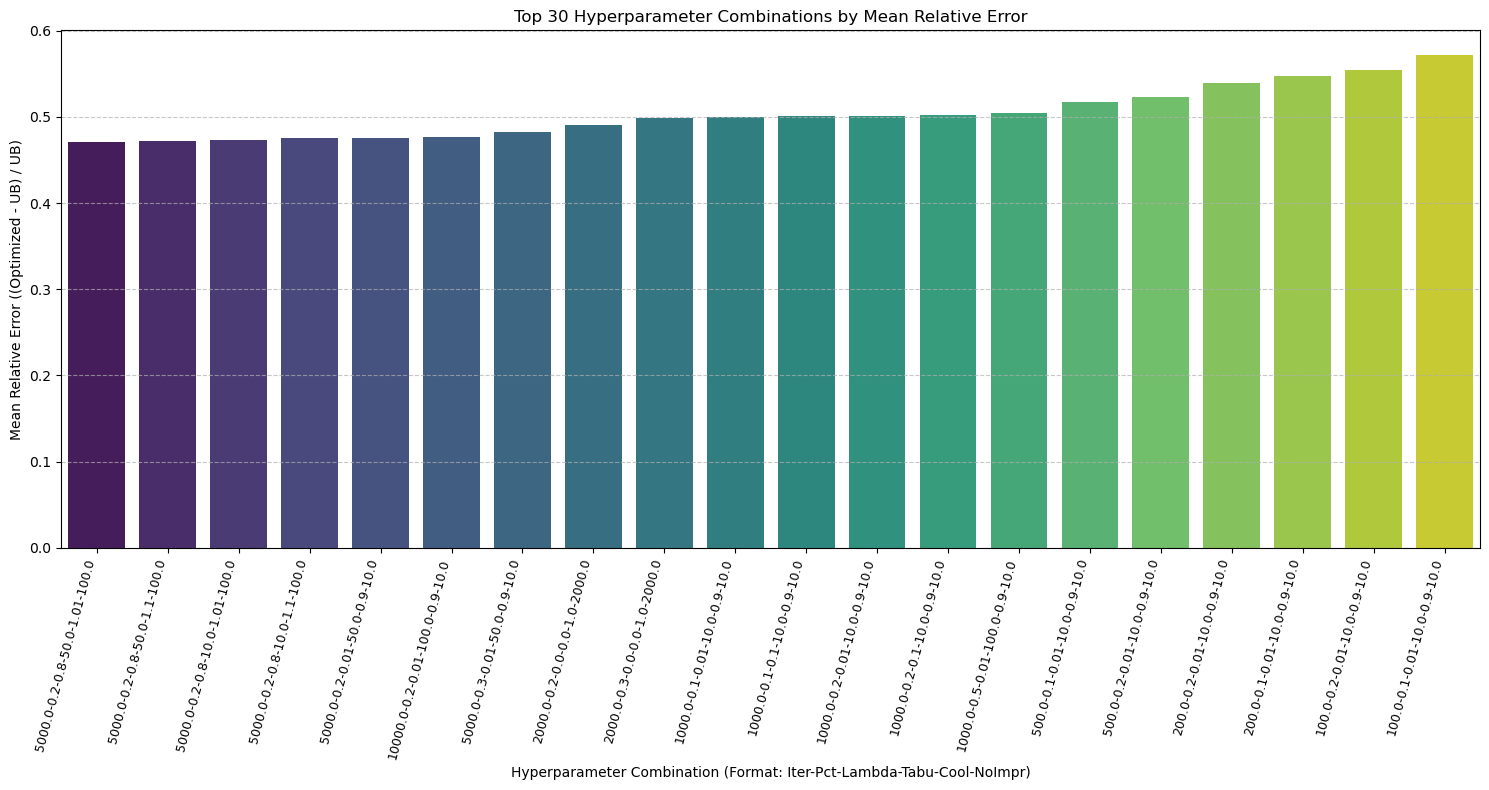

In [9]:
# 2. Load and combine algorithm results data
all_results_df = load_and_combine_results(csv_files)


if not all_results_df.empty:
    # 3. Add reference bounds to the combined results dataframe
    # This step modifies all_results_df directly
    all_results_df['UpperBound_Ref'] = all_results_df['Instance'].map(benchmark_upper_bounds)

    # Check how many rows got a bound assigned
    bounds_assigned = all_results_df['UpperBound_Ref'].notna().sum()
    print(f"\nAssigned reference upper bounds to {bounds_assigned} out of {len(all_results_df)} result rows.")
    if bounds_assigned < len(all_results_df):
         print("Warning: Some rows did not receive a reference bound. Check instance name matching.")
         print("Instances in results without matching bounds:",
               all_results_df[all_results_df['UpperBound_Ref'].isnull()]['Instance'].unique())


    # 4. Analyze hyperparameter performance
    hyperparameter_summary = analyze_hyperparameters(all_results_df, hyperparameter_columns)

    if hyperparameter_summary is not None and not hyperparameter_summary.empty:
        # 5. Print the best combination found
        best_combination = hyperparameter_summary.iloc[0]
        print("\n--- Best Hyperparameter Combination ---")
        print(best_combination)
        print(f"\nLowest Mean Relative Error: {best_combination['RelativeError']:.4f}")

        # 6. Plot the performance of top combinations
        print("\nGenerating performance chart...")
        plot_hyperparameter_performance(hyperparameter_summary, top_n=30) # Plot top 30 combinations

    else:
        print("\nCould not generate hyperparameter summary.")




In [10]:
# # Function to read the instances from Taillard (1989)
# def read_instances_from_file(filenames):
#     upper_bounds = {} # Initialize dictionary *outside* the loop
#     for filename in filenames:
#         with open(filename, 'r') as file:
#             lines = file.readlines()
#             i = 0
#             instance_counter = 1 # Counter for instances within *this* file
#             while i < len(lines):
#                 # Look for the header line indicating a new instance
#                 line_stripped = lines[i].strip()
#                 if line_stripped.startswith("Nb of jobs"):
#                     # The next line contains the parameters
#                     if i + 1 < len(lines):
#                         parts = [val for val in lines[i + 1].strip().split() if val] # Split and remove empty strings
#                         if len(parts) > 4:
#                             # Extract num_jobs, num_machines, and the upper bound (5th value, index 4)
#                             num_jobs = int(parts[0])
#                             num_machines = int(parts[1])
#                             upper_bound = int(parts[4]) # Assuming upper bound is the 5th value

#                             # Construct the instance name matching the results CSV format
#                             # Use os.path.basename to ensure only filename is used, not full path
#                             instance_name = f"{filename} - Instance {instance_counter}"
#                             upper_bounds[instance_name] = upper_bound
#                             # print(f"Extracted Upper Bound for {instance_name}: {upper_bound}")

#                             # Calculate how many lines to skip to get to the next instance header
#                             # Header line (1) + Parameter line (1) + Times lines (num_jobs) + Machines lines (num_jobs)
#                             # The +1 at the end accounts for the "Machines" header line before machine data
#                             lines_to_skip = 1 + 1 + num_jobs + 1 + num_jobs
#                             i += lines_to_skip
#                             instance_counter += 1
#                         else:
#                             print(f"Warning: Could not parse parameters line in {filename}: {lines[i+1].strip()}")
#                             i += 1 # Move to next line to avoid infinite loop
#                     else:
#                             print(f"Warning: Header found but no data line following in {filename} at line {i}")
#                             i += 1 # Header found but no data line? Move to next line.
#                 else:
#                     i += 1 # Move to the next line if it's not a header
#     return upper_bounds



In [11]:
# ub_files = [
#     "tai15_15.txt",
#     "tai20_15.txt",
#     "tai20_20.txt",
#     "tai30_15.txt",
#     "tai30_20.txt",
#     "tai50_15.txt",
#     "tai50_20.txt",
#     "tai100_20.txt"
# ]
# ub_all=read_instances_from_file(ub_files)

In [12]:
# csv_files = [
#     "results_makespanSA.csv",
#     "results_makespanSA2.csv",
#     "results_makespanSA3.csv",
#     "results_makespanSA4.csv"
# ]
# def load_and_combine_results(file_list):
#     """Loads data from multiple CSV files containing algorithm results and combines them."""
#     all_data = []
#     for f in file_list:
#         try:
#             df = pd.read_csv(f)
#             # df['source_file'] = f # Add source file info
#             all_data.append(df)
#             print(f"Successfully loaded results from {f}")
#         except Exception as e:
#             print(f"Error loading results {f}: {e}")

#     if not all_data:
#         print("Error: No results data loaded.")
#         return pd.DataFrame()

#     combined_df = pd.concat(all_data, ignore_index=True)
#     print(f"\nCombined results data has {len(combined_df)} rows.")
#     return combined_df

# load_and_combine_results(csv_files)


Reference Upper Bounds Loaded: {'tai15_15.txt - Instance 1': 1231, 'tai15_15.txt - Instance 2': 1244, 'tai15_15.txt - Instance 3': 1222, 'tai15_15.txt - Instance 4': 1181, 'tai15_15.txt - Instance 5': 1233, 'tai15_15.txt - Instance 6': 1243, 'tai15_15.txt - Instance 7': 1228, 'tai15_15.txt - Instance 8': 1220, 'tai15_15.txt - Instance 9': 1282, 'tai15_15.txt - Instance 10': 1259, 'tai20_15.txt - Instance 1': 1376, 'tai20_15.txt - Instance 2': 1377, 'tai20_15.txt - Instance 3': 1367, 'tai20_15.txt - Instance 4': 1345, 'tai20_15.txt - Instance 5': 1366, 'tai20_15.txt - Instance 6': 1371, 'tai20_15.txt - Instance 7': 1480, 'tai20_15.txt - Instance 8': 1413, 'tai20_15.txt - Instance 9': 1352, 'tai20_15.txt - Instance 10': 1362, 'tai20_20.txt - Instance 1': 1663, 'tai20_20.txt - Instance 2': 1626, 'tai20_20.txt - Instance 3': 1574, 'tai20_20.txt - Instance 4': 1660, 'tai20_20.txt - Instance 5': 1598, 'tai20_20.txt - Instance 6': 1657, 'tai20_20.txt - Instance 7': 1704, 'tai20_20.txt - Inst

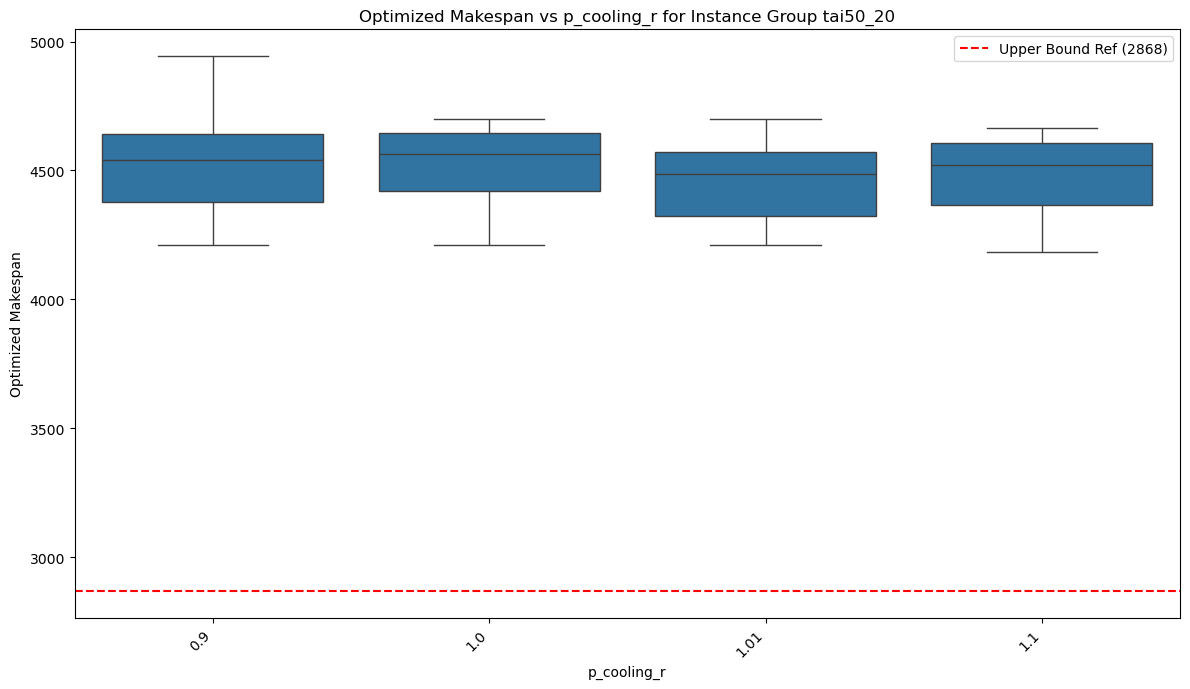


Sample data for tai50_20 including reference bound:
                     Instance  p_cooling_r  Optimized Makespan  UpperBound_Ref
60  tai50_20.txt - Instance 1          0.9                4577            2868
61  tai50_20.txt - Instance 2          0.9                4642            2902
62  tai50_20.txt - Instance 3          0.9                4210            2755
63  tai50_20.txt - Instance 4          0.9                4377            2702
64  tai50_20.txt - Instance 5          0.9                4536            2725


In [13]:

def separate_by_instance(df, benchmark_bounds):
    """
    Separates the combined dataframe into a dictionary of dataframes,
    one per base instance, and adds the reference upper bound based on the full instance name.
    """
    if 'Instance' not in df.columns or df.empty:
        print("Error: 'Instance' column missing or DataFrame empty.")
        return {}

    # Extract base instance name mainly for grouping/reporting purposes
    df['base_instance'] = extract_base_instance(df['Instance'])

    # Add the reference upper bound using the *full* instance name for lookup
    # The 'Instance' column from CSV should match the keys generated by read_instances_from_file
    df['UpperBound_Ref'] = df['Instance'].map(benchmark_bounds)

    # Handle parsing issues for base_instance (optional, for grouping)
    if df['base_instance'].isnull().any():
        print("Warning: Some base instance names could not be parsed from results.")

    # Handle missing upper bounds
    if df['UpperBound_Ref'].isnull().any():
        print("\nWarning: Some results rows did not match a benchmark upper bound:")
        missing_instances = df[df['UpperBound_Ref'].isnull()]['Instance'].unique()
        print(f"Instances without matching bounds: {list(missing_instances)}")


    # Group by BASE instance name for the dictionary structure
    instance_dfs = {}
    for name, group in df.groupby('base_instance'):
        if name is not None: # Ensure group name is valid
            instance_dfs[name] = group.copy() # Store the group (which now includes UpperBound_Ref)
        else:
            print("Warning: Found group with no base_instance name during separation.")


    print(f"\nSeparated data into {len(instance_dfs)} base instances: {list(instance_dfs.keys())}")
    # Check if any instance group is missing a reference bound (might indicate partial match)
    for name, df_instance in instance_dfs.items():
        if 'UpperBound_Ref' not in df_instance.columns or df_instance['UpperBound_Ref'].isnull().all():
            print(f"Warning: Base instance group '{name}' has no reference Upper Bounds assigned.")
        elif df_instance['UpperBound_Ref'].isnull().any():
             print(f"Warning: Some rows within base instance group '{name}' are missing reference Upper Bounds.")


    return instance_dfs

# --- Graphing Function Example ---

def plot_makespan_vs_hyperparameter(instance_df, instance_name, hyperparameter_col, value_col='Optimized Makespan'):
    """
    Generates a box plot comparing a value column (e.g., Optimized Makespan)
    across different values of a specified hyperparameter for a given instance group.
    Plots the reference upper bound found in the first row of the group as a guide.
    """
    if instance_df.empty:
        print(f"No data to plot for instance group {instance_name}.")
        return
    if hyperparameter_col not in instance_df.columns:
        print(f"Error: Hyperparameter column '{hyperparameter_col}' not found for instance group {instance_name}.")
        return
    if value_col not in instance_df.columns:
        print(f"Error: Value column '{value_col}' not found for instance group {instance_name}.")
        return

    plt.figure(figsize=(12, 7))
    # Convert hyperparameter column to string for categorical plotting if it's numeric
    instance_df_plot = instance_df.copy()
    # Ensure the hyperparameter column exists before attempting conversion
    if hyperparameter_col in instance_df_plot.columns:
        instance_df_plot[hyperparameter_col] = instance_df_plot[hyperparameter_col].astype(str)
    else:
        # Handle the case where the column might be missing after all, though checked above
        print(f"Error: Column '{hyperparameter_col}' still missing before plotting.")
        return


    sns.boxplot(data=instance_df_plot, x=hyperparameter_col, y=value_col)

    # Check if reference upper bound exists and plot the first one found for this group
    # Note: This assumes the upper bound is the same for all sub-instances within the base group.
    # If bounds differ, this line represents only one of them.
    if 'UpperBound_Ref' in instance_df.columns and not instance_df['UpperBound_Ref'].isnull().all():
        # Find the first non-NaN value in the reference column for this group
        valid_bounds = instance_df['UpperBound_Ref'].dropna()
        if not valid_bounds.empty:
            ref_bound = valid_bounds.iloc[0] # Get the first non-NaN bound value
            plt.axhline(ref_bound, color='r', linestyle='--', label=f'Upper Bound Ref ({int(ref_bound)})')
            plt.legend()
            print(f"Plotting reference line using Upper Bound: {int(ref_bound)} for instance group {instance_name}")
        else:
            print(f"Could not find a valid reference bound value to plot for instance group {instance_name}")


    plt.title(f'{value_col} vs {hyperparameter_col} for Instance Group {instance_name}')
    plt.xlabel(hyperparameter_col)
    plt.ylabel(value_col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# --- Main Execution ---

# 1. Load benchmark upper bounds using the corrected function
benchmark_upper_bounds = read_instances_from_file(benchmark_files)
print("\nReference Upper Bounds Loaded:", benchmark_upper_bounds)

# 2. Load and combine algorithm results data
all_results_df = load_and_combine_results(csv_files)

if not all_results_df.empty:
    # 3. Separate data by base instance name and add reference bounds using full instance name match
    results_by_instance = separate_by_instance(all_results_df, benchmark_upper_bounds)

    # 4. Example: Plot results for a specific base instance group and hyperparameter
    target_instance_name = "tai50_20" # Choose a base instance group to plot
    hyperparameter_to_plot = "p_cooling_r" # Choose a hyperparameter column

    if target_instance_name in results_by_instance:
        print(f"\nGenerating plot for instance group: {target_instance_name}")
        # Access the specific DataFrame for the instance group
        instance_data_to_plot = results_by_instance[target_instance_name]

        # Check if *any* reference bound was successfully added before plotting
        if 'UpperBound_Ref' in instance_data_to_plot.columns and not instance_data_to_plot['UpperBound_Ref'].isnull().all():
             # Print the first valid bound found for reference
             first_valid_bound = instance_data_to_plot['UpperBound_Ref'].dropna()
             if not first_valid_bound.empty:
                 print(f"Reference Upper Bound (example from group): {first_valid_bound.iloc[0]}")
             else:
                 print(f"Warning: No valid reference Upper Bound found for plotting {target_instance_name}")

        else:
             print(f"Warning: No reference Upper Bound column found or all values are NaN for plotting {target_instance_name}")

        plot_makespan_vs_hyperparameter(
            instance_data_to_plot,
            target_instance_name,
            hyperparameter_to_plot
        )

        # Display some data including the reference bound
        print(f"\nSample data for {target_instance_name} including reference bound:")
        # Select columns robustly, checking if they exist first
        cols_to_show = ['Instance', hyperparameter_to_plot, 'Optimized Makespan', 'UpperBound_Ref']
        cols_exist = [col for col in cols_to_show if col in instance_data_to_plot.columns]
        print(instance_data_to_plot[cols_exist].head())


    else:
        print(f"\nInstance group '{target_instance_name}' not found in the results.")

else:
    print("\nNo results data was loaded, cannot proceed with analysis.")

